**Concentratable Entanglement** 

In [105]:
import numpy as np
import math, cmath
from itertools import chain, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.quantum_info import DensityMatrix, Operator, Statevector, partial_trace, random_statevector

def power_set(input_list):
    '''Get the power set of the input set
       (For simplicity, we deal with list instead of set)
    '''
    # Use chain.from_iterable and combinations to generate the power set
    power_list = list(chain.from_iterable(combinations(input_list, r) for r in range(len(input_list)+1)))
    return power_list

def qiskit_shit(matrix):
    '''Map the operator martrix accross the off-diagonal to make it compatitble with Qiskit
    Example:
        Input:  [[2, 2, 2, 2, 0],
                 [2, 2, 2, 0, 1],
                 [2, 2, 0, 1, 1],
                 [2, 0, 1, 1, 1],
                 [0, 1, 1, 1, 1]]
        Output: [[1, 1, 1, 1, 0],
                 [1, 1, 1, 0, 2],
                 [1, 1, 0, 2, 2],
                 [1, 0, 2, 2, 2],
                 [0, 2, 2, 2, 2]]
    '''

    n = matrix.shape[0]

    # Iterate over the upper triangle of the matrix
    for i in range(n-1):
        for j in range(0, n-i-1):
            # Swap symmetric elements across the off-diagonal
            matrix[i, j], matrix[-j-1, -i-1] = matrix[-j-1, -i-1], matrix[i, j]

    return matrix

def qiskit_statevec_map(statevec_qiskit, N):
    '''Qiskit orders qubits in a endian way, 
       this function is used to convert a state vector that written in endian ordering to a normal ordering
    '''
    statevec_qiskit = np.array(statevec_qiskit)
    statevec_normal = np.zeros_like(statevec_qiskit, dtype=complex)
    
    for i in range(2**N):
        binary_index = format(i, f'0{N}b')  # Convert the index to an N-bit binary string
        reversed_index = int(binary_index[::-1], 2)  # Reverse the binary string and convert it back to an integer
        
        statevec_normal[reversed_index] = statevec_qiskit[i]

    return Statevector(statevec_normal)


def fourier_trans(K, dagger=False):
    '''Get the matrix representation of Fourier transform operator and its inverse
    Args:
        K: number of levels of the qudit
        dagger: Ture -> inverse Fourier transform
                False -> Fourier transform
    Yields: matrix representation of FT and IFT
        
    '''

    L = math.ceil(math.log2(K)) # number of qubits to represent one K-level qudit

    w = cmath.exp(2*cmath.pi*1j/K)
    if dagger:
        w = cmath.exp(-2*cmath.pi*1j/K)

    F_tmp = np.ones((K,K), dtype=complex)
    for i in range(K):
        for j in range(K):
            F_tmp[i,j] = w**(i*j)

    F = 1/(K**0.5)*F_tmp
    I = np.identity(2**L-K)

    return np.block([[F, np.zeros((K,2**L-K))],
                   [np.zeros((2**L-K,K)), I]])


def cyc_determine(m, t_row, t_col, K):
    '''Determine if one binary string can be shifted to another one by m steps
    Args:
        m: index of the basis of the ancilla qudit
        (t_row, t_col): index of element of matrix (in basis of target qubits)
        K: number of bits of the binary expression of t_row and t_col
    Yields:
        value: the value of the element at (t_row, t_col) 
    '''
    # m, t_row, t_col are all decimal integers
    ttt_row = bin(t_row).replace('0b', '') # t'
    ttt_row = ttt_row.zfill(K)
    ttt_col = bin(t_col).replace('0b', '') # t
    ttt_col = ttt_col.zfill(K)

    value = 0
    if ttt_row == ttt_col[m:] + ttt_col[:m]:
        value = 1
    
    return value

def sub_block(m, K):
    '''Get the m-th block matrix of the the matrix representation of the controlled cyclic operator
    Args:
        m: index of the basis of the ancilla qudit
        K: number of bits of the binary expression of t_row and t_col
    Yields:
        block: m-th block matrix
    '''
    block = np.zeros((2**K,2**K))
    for i in range(2**K):
        for j in range(2**K):
            block[i,j] = cyc_determine(m, i, j, K)
            
    return block

def direct_sum(*matrices):
    '''Get the direct sum of all the input square matrices'''
    
    # Get the size of the resulting matrix
    total_size = sum(matrix.shape[0] for matrix in matrices)
    result_matrix = np.zeros((total_size, total_size), dtype=matrices[0].dtype)

    # Populate the block diagonal matrix
    current_row, current_col = 0, 0
    for matrix in matrices:
        size = matrix.shape[0]
        result_matrix[current_row:current_row+size, current_col:current_col+size] = matrix
        current_row += size
        current_col += size

    return result_matrix


# controlled cyclic permutations
def control_cyclic_perm(L, K):
    '''Get the matrix representation of the controlled cyclic operator'''
    
    block_dict = {}

    for m in range(2**L):
        ccc = bin(m).replace('0b', '')
        block_dict[ccc.zfill(L)] = sub_block(m, K)

    return direct_sum(*block_dict.values())

In [106]:
N = 3 # number of qubits of each state |\psi>, also number of qudits required
K = 3 # number of levels of the qudit, also number of copies of state |\psi>
L = math.ceil(math.log2(K)) # number of qubits to represent one K-level qudit

# psi_state = qiskit_statevec_map( Statevector([1/2**0.5, 0, 0, 0, 0, 0, 0, 1/2**0.5]), N )
psi = random_statevector(2**N)
psi_state = qiskit_statevec_map(psi, N )

# Name the N ancilla qudits, each of which is encoded by L qubits
ancilla_qudits = {}
for i in range(N):
    qudit_index = f"qudit_{i}"
    ancilla_qudits[qudit_index] = QuantumRegister(L, 'ancilla qudit '+str(i)) 

# Name the N L-bit classical bits, which is for storing the measurement results of the N ancilla qudits
classical_bits = {}
for i in range(N):
    cbit_index = f"cbit_{i}"
    classical_bits[cbit_index] = ClassicalRegister(L, 'classical bit '+str(i)) 

# Name the K copies of each N-qubit state |\psi>
copies = {}
for i in range(K):
    copy_index = f"copy_{i}"
    copies[copy_index] = QuantumRegister(N, 'copy '+str(i)) 

# Define Fourier transform and its inverse operator for qudits
FT = Operator(fourier_trans(K, dagger=False)).to_instruction()
FT.label = "   FT  "
FT_dagger = Operator(fourier_trans(K, dagger=True)).to_instruction()
FT_dagger.label = "   IFT  "

# Define the qudit-controlled cyclic permutation operator
CCP = Operator(control_cyclic_perm(L, K)).to_instruction()
CCP.label = "   CCP  "

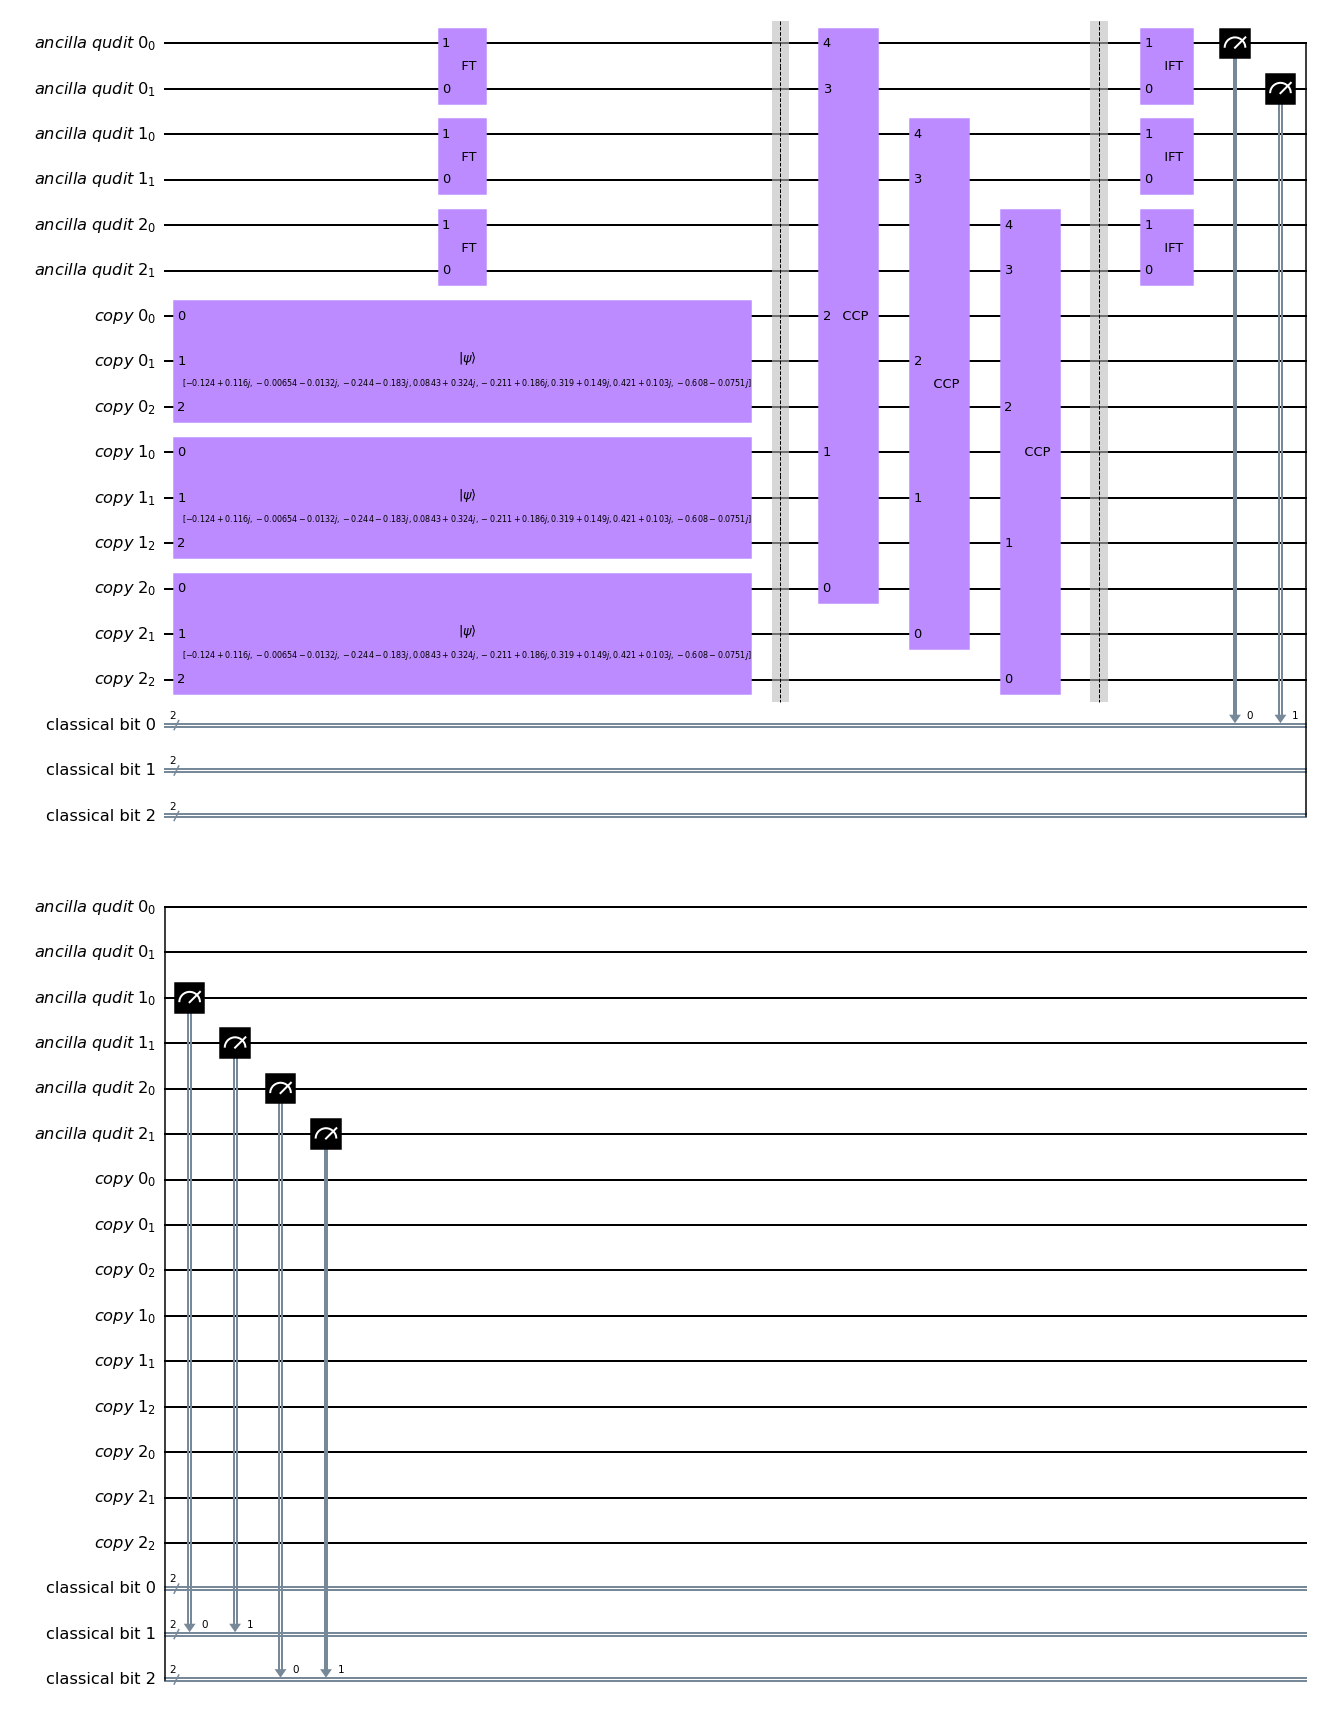

In [107]:
# Write the quantum circuit
qc = QuantumCircuit(*ancilla_qudits.values(), *copies.values(), *classical_bits.values()) 

# Initialize the psi states
for i in range(K):
    qc.initialize(psi_state, copies['copy_'+str(i)])

# Fourier Transform on ancillas
for i in range(N):
    qc.append(FT, ancilla_qudits['qudit_'+str(i)][::-1])
qc.barrier(*ancilla_qudits.values(), *copies.values())

# Controlled cyclic permutation operators
for i in range(N):  
    register_index_tmp = []
    for j in range(K):
        register_index_tmp.append(copies['copy_'+str(j)][i])
        register_index = ancilla_qudits['qudit_'+str(i)][0:L] + register_index_tmp
    qc.append(CCP, register_index[::-1])
qc.barrier(*ancilla_qudits.values(), *copies.values())

# Inverse Fourier Transform on ancillas
for i in range(N):
    qc.append(FT_dagger, ancilla_qudits['qudit_'+str(i)][::-1])

# Measure ancillas
for i in range(N):
    qc.measure(ancilla_qudits['qudit_'+str(i)], classical_bits['cbit_'+str(i)])

qc.draw('mpl')

In [108]:
num_of_shots = 1000

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend, shots=num_of_shots)
result = job.result().get_counts()
result


{'10 01 00': 56,
 '00 00 00': 733,
 '00 10 01': 34,
 '01 10 00': 56,
 '10 10 10': 24,
 '10 00 01': 24,
 '01 00 10': 26,
 '00 01 10': 23,
 '01 01 01': 24}

In [109]:
def compute_tr(set_of_interest, result, num_of_shots):
    '''Calculate the tr given the measurement results of the circuits'''

    new_result = {}
    for binary_key in result:
        # Convert the qubit measurement outcome to qudit measurement outcome (z strings)
        digital_key = tuple([int(substring[::-1], 2) for substring in binary_key.split()]) 
        new_result[digital_key[::-1]] = result[binary_key] # Reverse the measurement outcome in terms of qudit order beacuse Qiskit use endian order

    count = 0 # number of z strings of ineterest
    for z_string in new_result:
        tmp = sum(z_string[index] for index in set_of_interest)
        if tmp % K == 0:
            count += new_result[z_string]

    return (K * count/num_of_shots - 1) / (K-1) #, new_result



def powerset(s):
    """powerset: find the powerset of s"""
    x = len(s)
    result = []
    for i in range(1 << x):
        result.append([s[j] for j in range(x) if (i & (1 << j))])
    return result

def compute_CE(s):
    '''Compute CE for the given set s'''
    ps = powerset(s)
    summ = 0
    for i in range(len(ps)):
        summ += compute_tr(ps[i], result, num_of_shots)
    return 1 - 1 / 2**(len(s)) * summ


In [114]:
S = list(range(N)) # Set of labels for each qubit of psi_state
set_of_interest = [0,1] # Set of labels of qubits of interest in terms of CE
alpha = power_set(set_of_interest)

# compute_tr(set_of_interest, result, num_of_shots)
compute_CE(set_of_interest)

0.21824999999999994

In [115]:
"""
correct concentratable entanglement 
s: indices
K: \rho power
psi: input state
"""

def con_ent(s, K, psi):
    rho = psi.H * psi
    n = np.arange(int(np.log2(np.size(psi))))
    # print(n)
    cs = len(s)
    ps = powerset(s)
    summ = 0
    for i in range(len(ps)):
        
        alpha = ps[i]
        alpha = list(set(n).difference(set(alpha)))
        summ = summ + np.trace(np.matrix(partial_trace(rho,alpha))**K)
        # print(alpha, qi.partial_trace(rho,alpha))
    result = 1 - 1 / 2**cs * summ
    return result


con_ent(set_of_interest, K, np.matrix(psi))

(0.2062442532047517+3.794825432609298e-18j)